In [ ]:
# Install required library
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 6.6 MB 31.0 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, LSTM
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from transformers import TFBertModel, BertTokenizer

from sklearn.utils import shuffle

plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [ ]:
# Upload datasets for training
from google.colab import files
uploaded = files.upload()

Saving data_complete2.0.csv to data_complete2.0 (1).csv


In [ ]:
import io
# Read uploaded Dataset
df = pd.read_csv(io.BytesIO(uploaded["data_complete2.0.csv"]))

In [ ]:
# Inspect Dataset
df.head()

,berita,label
0,"Gejala Covid Masih Ada, Stephen Colbert Tunda ...",0
1,Tidak Ada Klaim dari Anies Mengenai Merancang ...,0
2,Badan Narkotika Nasional (BNN) mengimbau warga...,0
3,Sri Mulyani Siapkan Anggaran Bansos Rp349 Tril...,0
4,Princess Qajar Simbol Kecantikan di Persia Sam...,1


In [ ]:
df.shape

(7445, 2)

In [ ]:
df = shuffle(df)

In [ ]:
#get BERT layer
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p1")
#get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

In [ ]:
encode = bert_tokenizer.encode("Halo Siapa nama kamu?")
decode = bert_tokenizer.decode(encode)

print("Encode: ", encode)
print("Decode: ", decode)

Encode:  [2, 9302, 1545, 712, 508, 30477, 3]
Decode:  [CLS] halo siapa nama kamu? [SEP]


In [ ]:
df.isnull().sum()

berita    0
label     0
dtype: int64

In [ ]:
df.fillna('', inplace=True)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('indonesian')

In [ ]:
def preprocess(text):
    text = text.lower() # lowercase
    
    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
df["berita"] = df['berita'].apply(lambda x: preprocess(x))

In [ ]:
df.head()

,berita,label
0,gejala covid stephen colbert tunda syuting epi...,0
1,klaim anies merancang lapangan banteng 0 berte...,0
2,badan narkotika nasional (bnn) mengimbau warga...,0
3,sri mulyani siapkan anggaran bansos rp349 tril...,0
4,princess qajar simbol kecantikan persia 13 pri...,1


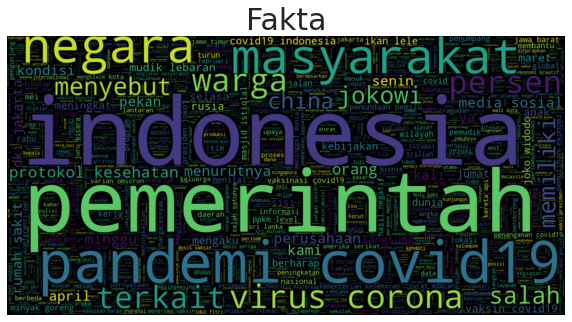

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.label == 0].berita))
plt.axis('off')
plt.title('Fakta')
plt.imshow(wc,interpolation = 'bilinear')

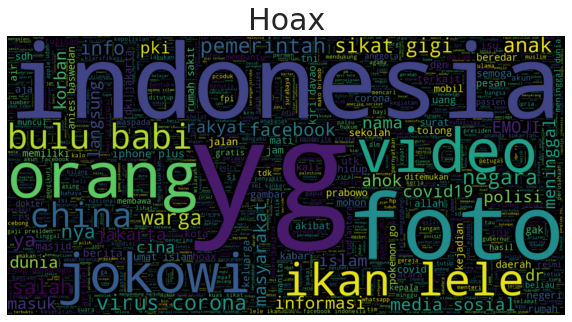

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.label == 1].berita))
plt.axis('off')
plt.title('Hoax')
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
f,ax = plt.subplots(1,2,figsize=(14,6))
dataset['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = dataset, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

In [ ]:
x_train_bert = df["berita"]
y_train_bert = df["label"]

In [ ]:
hoax = 1
fakta = 0
for label in y_train_bert:
    if label == 1:
        hoax+= 1
    if label == 0:
        fakta+=1
print("Jumlah Berita Hoax: ", hoax)
print("Jumlah Berita Fakta: ", fakta)

Jumlah Berita Hoax:  3723
Jumlah Berita Fakta:  3723


In [ ]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_model.bert([input_ids,attention_masks])
output = output[1]
# maybe use recurrent_dropout next or even both
net = tf.keras.layers.Dense(32,activation='relu')(output)
#net = SpatialDropout1D(0.5)(net)
#net = Bidirectional(LSTM(16, dropout=0.5))(net)
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)

outputs = net
model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  124441344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [ ]:
# Prepare Hyper Parameter and Callbacks
EPOCHS = 25
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2

ACCURACY_THRESHOLD = 0.99
VAL_ACCURACY_THRESHOLD = 0.87
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > ACCURACY_THRESHOLD and logs.get('val_accuracy') > VAL_ACCURACY_THRESHOLD):
            print("\nReached {} on training accuracy and {} on validation accuracy stop training".format("99%","87%"))
            self.model.stop_training = True

In [ ]:
callbacks  = MyCallback()
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_bert,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,      
    callbacks=[callbacks])

Epoch 1/25
608/745 [=======================>......] - ETA: 13:26 - loss: 0.4059 - accuracy: 0.8285

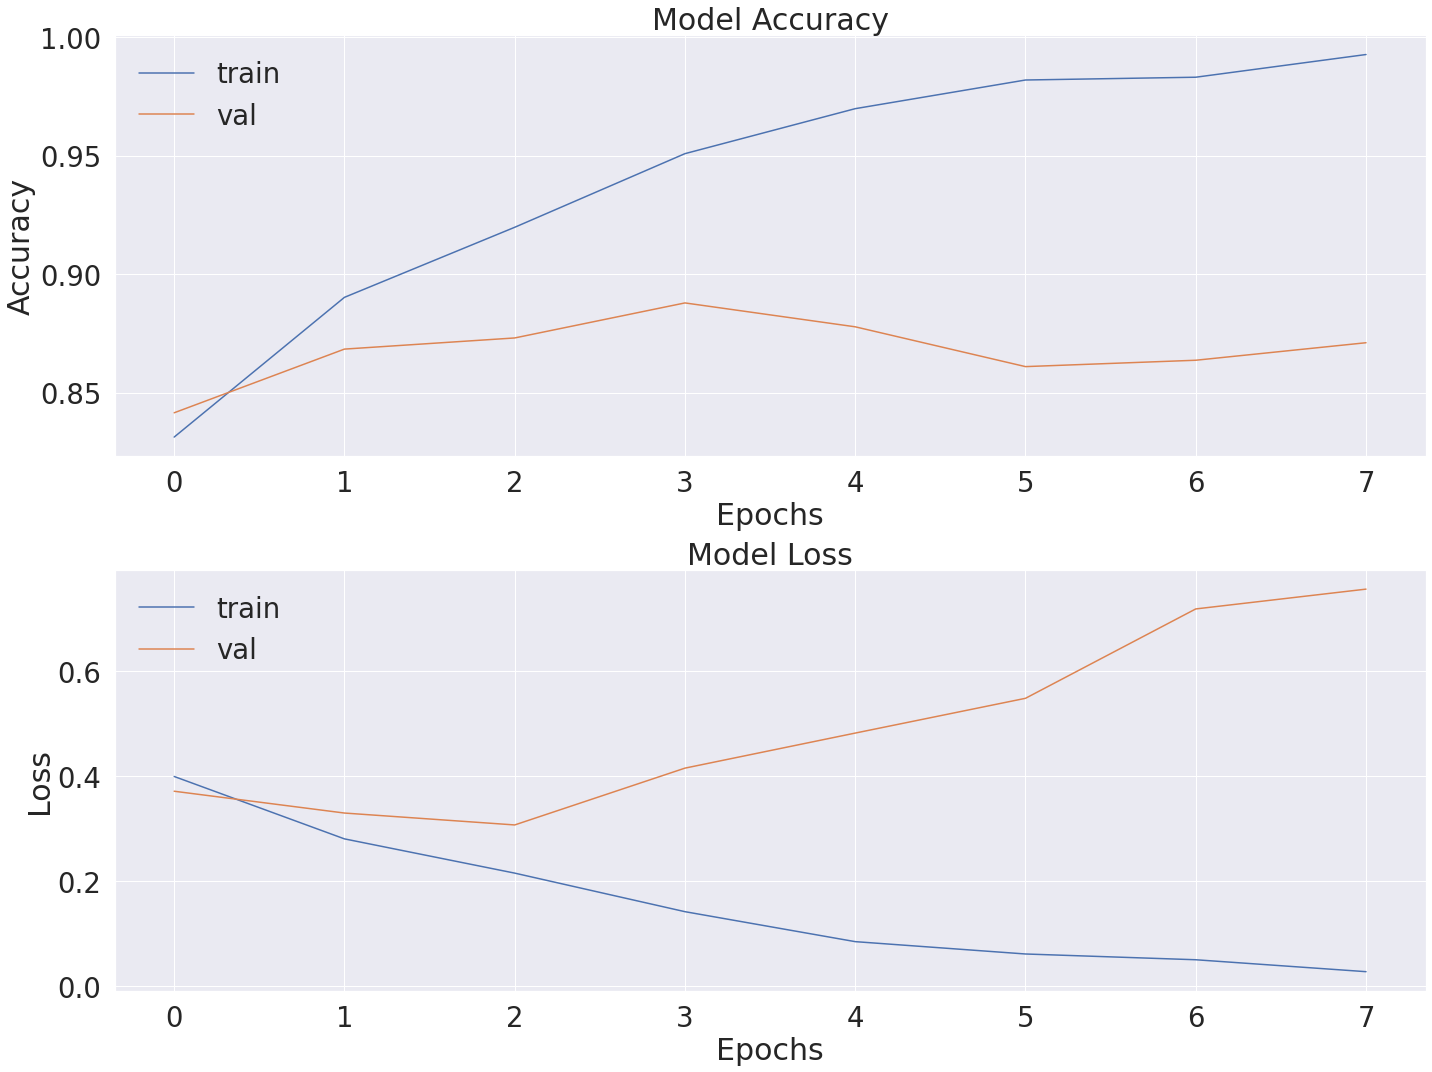

In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train', 'val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

In [ ]:
news_sample = ["Ikan lele merupakan salah satu makanan favorit di Indonesia. Selain harganya murah, rasanya juga sangat enak. Meski demikian, ada sebagian masyarakat yang takut menikmati masakan dari ikan air tawar tersebut. Mereka beranggapan jika ikan lele penyebab kanker dan penyakit lainnya.",
               "Jakarta, Penyakit stroke saat ini bukanlah penyakit yang langka mengingat bagaimana gaya hidup masyarakat saat ini. Stres, jarang berolah raga, minum minuman beralkohol, makan tidak teratur, dan memilih makanan cepat saji sudah menjadi hal biasa. Dan ternyata hal-hal inilah yang memicu penyakit stroke. Anda pun wajib waspada terhadap gejalanya. Pingsan tiba-tiba atau mengalami kemiringan mulut merupakan salah satu tanda-tanda stroke. Orang-orang seperti ini harus cepat mendapatkan pertolongan pertama.",
               "Pokemon aku yahudi adalah salah satu hal yang sering di share di grup sebutan favorit di indonesia",
               "Pokemon aku yahudi: CNN Indonesia",
               "Seorang wanita yang tengah hamil delapan bulan, Fitri (32), berhasil selamat dari peristiwa tanah longsor di Kampung Pasir Pogor, Desa Cipelang, Cijeruk, Kabupaten Bogor, Jawa Barat. Fitri sempat tertimbun longsor selama lima menit sebelum ditemukan warga.Ada lima menit saya sama anak-anak terjebak, sebelum ditolong warga. Pada ngeliat kepala anak-anak terus diangkat. Suami saya nggak tertolong, posisinya dekat pintu dapur, ungkap Fitri saat ditemui di tempatnya mengungsi tak jauh dari lokasi kejadian, Ahad.",
               "Innalilahi wainnailaihi Rojiun … Tragis Lettu Marinir Muhammad Ikbal Gugur Ditembak KKB Saat Sujud Sholat Isya",
               "Maudy Ayunda mengejutkan publik usai dikabarkan resmi menikah dengan kekasihnya pada Minggu (22/5). Hal itu muncul setelah dirinya selama ini jarang mengungkapkan hubungan asmara dengan seseorang.",
               "Covid merupakan virus buatan ukraina: CNN Indonesia",
               "Presiden Jokowi menghadang tank sendirian di ukraina",
               "Subhanallah pakdhe menghadang tank sendirian di kerusuhan ukraina"]

In [ ]:
test_input = bert_encode(news_sample, 60)
preds = model.predict(test_input)
preds

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([[4.7885829e-01],
       [8.3993532e-02],
       [9.6535116e-01],
       [9.9995482e-01],
       [1.1663712e-03],
       [9.9996209e-01],
       [2.8888643e-04],
       [9.9937975e-01],
       [9.9847442e-01],
       [6.4038342e-01]], dtype=float32)

In [ ]:
import pandas as pd
THRESHOLD = 0.70
pred_df = pd.DataFrame(columns=['news', 'prediction'])
pred_df['news'] = news_sample
pred_df['prediction'] = preds

pred_df['prediction'] = pred_df['prediction'].apply(lambda x: 'Hoax' if x > THRESHOLD else 'Fakta')

pred_df

,news,prediction
0,Ikan lele merupakan salah satu makanan favorit...,Fakta
1,"Jakarta, Penyakit stroke saat ini bukanlah pen...",Fakta
2,Pokemon aku yahudi adalah salah satu hal yang ...,Hoax
3,Pokemon aku yahudi: CNN Indonesia,Hoax
4,Seorang wanita yang tengah hamil delapan bulan...,Fakta
5,Innalilahi wainnailaihi Rojiun … Tragis Lettu ...,Hoax
6,Maudy Ayunda mengejutkan publik usai dikabarka...,Fakta
7,Covid merupakan virus buatan ukraina: CNN Indo...,Hoax
8,Presiden Jokowi menghadang tank sendirian di u...,Hoax
9,Subhanallah pakdhe menghadang tank sendirian d...,Fakta


In [ ]:
# Save trained model
model.save("saved_model/indobert-base-p1-87")

In [ ]:
import pickle

# Save tokenizer using pickle
with open('indobert-base-p1-tokenizer.pickle', 'wb') as handle:
    pickle.dump(bert_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Utility to zip and download a directory
#@markdown Use this method to zip and download a directory. For ex. a TB logs 
#@markdown directory or a checkpoint(s) directory.

from google.colab import files
import os

dir_to_zip = '/content/saved_model/indobert-base-p1-87' #@param {type: "string"}
output_filename = 'saved_model.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )